In [2]:
import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType,StructField, StringType

# Crear una SparkSession
spark = SparkSession \
    .builder \
    .appName("Test") \
    .getOrCreate()

# Using list of Row type
datos = [Row("Finanzas",10), 
        Row("Mercadotecnia",20), 
        Row("Ventas",30), 
        Row("TI",40) 
      ]
esquema = ["departamento","identificador"]
df = spark.createDataFrame(data=datos, schema = esquema)
df.printSchema()
df.show(truncate=False)

# Convert list to RDD
# Aquí, `rdd` es una forma de representar los datos para que puedan ser procesados en paralelo.
# `parallelize` convierte datos como listas o tuplas en una estructura que se puede distribuir
# y procesar en múltiples nodos de un clúster de computadoras, aprovechando el procesamiento paralelo.
#rdd = spark.sparkContext.parallelize(df)

# Sin embargo, en este caso, `df.rdd` ya hace este trabajo con el DataFrame (df) de manera más directa,
# convirtiéndolo en un RDD (Resilient Distributed Dataset), que es un tipo de estructura de datos
# que Spark usa para el procesamiento distribuido de grandes cantidades de datos.

rdd = df.rdd


# Convertir el RDD a una lista en memoria (esto puede ser costoso con grandes cantidades de datos)
rdd_list = rdd.collect()

# Mostrar los primeros elementos del RDD
for item in rdd_list:
    print(item)

root
 |-- departamento: string (nullable = true)
 |-- identificador: long (nullable = true)

+-------------+-------------+
|departamento |identificador|
+-------------+-------------+
|Finanzas     |10           |
|Mercadotecnia|20           |
|Ventas       |30           |
|TI           |40           |
+-------------+-------------+

Row(departamento='Finanzas', identificador=10)
Row(departamento='Mercadotecnia', identificador=20)
Row(departamento='Ventas', identificador=30)
Row(departamento='TI', identificador=40)


In [3]:
df.dtypes

[('departamento', 'string'), ('identificador', 'bigint')]

In [4]:
df.describe()

DataFrame[summary: string, departamento: string, identificador: string]

In [5]:
import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql.functions import *

# Definimos las columnas y los datos a partir de los cuales se creará un DataFrame
columns = ["language", "users_count"]
data = [("Java", "20000"), ("Python", "100000"), ("Scala", "3000")]

# Convertimos la lista de datos en un RDD (Resilient Distributed Dataset)
rdd = spark.sparkContext.parallelize(data)

# Creamos un DataFrame a partir del RDD sin especificar nombres de columnas.
# PySpark asignará automáticamente nombres genéricos a las columnas (como '_1', '_2', etc.).
dfFromRDD1 = rdd.toDF()
dfFromRDD1.printSchema()  # Imprimimos el esquema del DataFrame generado (columnas con nombres genéricos).

# Creamos un DataFrame a partir del RDD especificando los nombres de las columnas explícitamente.
dfFromRDD1 = rdd.toDF(columns)  
dfFromRDD1.printSchema()  

# Usamos `createDataFrame` para convertir el RDD en un DataFrame, y luego asignamos los nombres de las columnas usando `toDF()`.
dfFromRDD2 = spark.createDataFrame(rdd).toDF(*columns)  
dfFromRDD2.printSchema()

# Creamos el DataFrame directamente a partir de los datos (sin necesidad de un RDD).
# Especificamos los nombres de las columnas utilizando `toDF()`.
dfFromData2 = spark.createDataFrame(data).toDF(*columns)
dfFromData2.printSchema()

# Convertimos los datos en filas de tipo `Row` y luego creamos un DataFrame.
# `Row` permite una representación estructurada de los datos como filas.
rowData = map(lambda x: Row(*x), data)
dfFromData3 = spark.createDataFrame(rowData, columns)
dfFromData3.printSchema() 


root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)

root
 |-- language: string (nullable = true)
 |-- users_count: string (nullable = true)

root
 |-- language: string (nullable = true)
 |-- users_count: string (nullable = true)

root
 |-- language: string (nullable = true)
 |-- users_count: string (nullable = true)

root
 |-- language: string (nullable = true)
 |-- users_count: string (nullable = true)



In [6]:
from pyspark.sql.functions import explode, map_keys
from pyspark.sql.functions import col

# Definimos un conjunto de datos con una lista de tuplas, donde cada tupla contiene un nombre y un diccionario de propiedades.
dictionary = [
    ('James', {'hair': 'black', 'eye': 'brown'}),
    ('Michael', {'hair': 'brown', 'eye': None}),
    ('Robert', {'hair': 'red', 'eye': 'black'}),
    ('Washington', {'hair': 'grey', 'eye': 'grey'}),
    ('Jefferson', {'hair': 'brown', 'eye': ''})
]

# Creamos un DataFrame de PySpark con este conjunto de datos, usando la lista de nombres de las columnas.
df = spark.createDataFrame(data=dictionary, schema=['name', 'properties'])
df.printSchema()
df.show(truncate=False)

# Usamos un esquema estructurado más avanzado con StructType y MapType.
from pyspark.sql.types import StructField, StructType, StringType, MapType, IntegerType

# Definimos el esquema con un tipo de datos MapType para la columna 'properties'.
schema = StructType([
    StructField('name', StringType(), True),
    StructField('properties', MapType(StringType(), StringType()), True)
])

# Creamos un DataFrame con el nuevo esquema.
df2 = spark.createDataFrame(data=dictionary, schema=schema)
print("Esquema del df2")
df2.printSchema()
df2.show(truncate=False)

# Aquí usamos `rdd.map()` junto con una función `lambda` para transformar el DataFrame original.
# La función `lambda` se aplica a cada fila del RDD. Toma cada fila `x` y extrae los valores 'hair' y 'eye' del diccionario 'properties'.
# `lambda x: (x.name, x.properties["hair"], x.properties["eye"])` toma cada fila, accede a los valores del diccionario y devuelve una nueva tupla con el nombre, el color del cabello y el color de los ojos.
df3 = df.rdd.map(lambda x: (x.name, x.properties["hair"], x.properties["eye"])) \
    .toDF(["name", "hair", "eye"])
print("Esquema del df3")
df3.printSchema()
df3.show()

print("Esquema del variación 1")
# Otra forma de hacerlo, usando las funciones de PySpark para acceder a los elementos del diccionario 'properties'.
df.withColumn("hair", df.properties.getItem("hair")) \
    .withColumn("eye", df.properties.getItem("eye")) \
    .drop("properties") \
    .show()

print("Esquema del variación 2")
# Otra variación del anterior, usando la sintaxis directa para acceder a los elementos del diccionario 'properties'.
df.withColumn("hair", df.properties["hair"]) \
    .withColumn("eye", df.properties["eye"]) \
    .drop("properties") \
    .show()

# Aquí usamos `explode()` y `map_keys()` para convertir las claves del diccionario 'properties' en columnas individuales.
# Primero obtenemos las claves del diccionario 'properties' con `map_keys(df.properties)`, luego las "explotamos" usando `explode()`.
keysDF = df.select(explode(map_keys(df.properties))).distinct()

# Usamos `map(lambda x: x[0])` para extraer solo la clave (en lugar de una tupla clave-valor).
keysList = keysDF.rdd.map(lambda x: x[0]).collect()

# Generamos las columnas a partir de las claves, usando `col("properties").getItem(x)` para acceder a los valores correspondientes.
keyCols = list(map(lambda x: col("properties").getItem(x).alias(str(x)), keysList))

# Finalmente, seleccionamos el nombre y todas las nuevas columnas generadas, usando `*keyCols` para incluir todas las columnas dinámicamente.
df.select(df.name, *keyCols).show()


root
 |-- name: string (nullable = true)
 |-- properties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)

+----------+-----------------------------+
|name      |properties                   |
+----------+-----------------------------+
|James     |{eye -> brown, hair -> black}|
|Michael   |{eye -> NULL, hair -> brown} |
|Robert    |{eye -> black, hair -> red}  |
|Washington|{eye -> grey, hair -> grey}  |
|Jefferson |{eye -> , hair -> brown}     |
+----------+-----------------------------+

Esquema del df2
root
 |-- name: string (nullable = true)
 |-- properties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)

+----------+-----------------------------+
|name      |properties                   |
+----------+-----------------------------+
|James     |{eye -> brown, hair -> black}|
|Michael   |{eye -> NULL, hair -> brown} |
|Robert    |{eye -> black, hair -> red}  |
|Washington|{eye -> grey, hair

In [7]:
# Definir el esquema del DataFrame
schema = StructType([
    StructField("Name", StringType(), True),
    StructField("Age", IntegerType(), True),
    StructField("Experience", IntegerType(), True),
    StructField("Salary", IntegerType(), True)
])

# Crear los datos
data = [
    ("Krish", 31, 10, 30000),
    ("Sudhanshu", 30, 8, 25000),
    ("Sunny", 29, 4, 20000),
    ("Paul", 24, 3, 20000),
    ("Harsha", 21, 1, 15000),
    ("Shubham", 23, 2, 18000),
    ("Mahesh", None, None, 40000),
    (None, 34, 10, 38000),
    (None, 36, None, None)
]

# Crear el DataFrame
df = spark.createDataFrame(data, schema=schema)

# Mostrar el DataFrame
df.show()

+---------+----+----------+------+
|     Name| Age|Experience|Salary|
+---------+----+----------+------+
|    Krish|  31|        10| 30000|
|Sudhanshu|  30|         8| 25000|
|    Sunny|  29|         4| 20000|
|     Paul|  24|         3| 20000|
|   Harsha|  21|         1| 15000|
|  Shubham|  23|         2| 18000|
|   Mahesh|NULL|      NULL| 40000|
|     NULL|  34|        10| 38000|
|     NULL|  36|      NULL|  NULL|
+---------+----+----------+------+



In [8]:
from pyspark.ml.feature import Imputer

#    Se crea una instancia de Imputer, que es una clase en PySpark utilizada para
#    llenar los valores nulos en las columnas especificadas. 
#    El imputador permite elegir entre diferentes estrategias para llenar valores nulos.
imputer = Imputer(
    #    Aquí, 'inputCols' se configura con las columnas que queremos completar
    #    cuando existan valores nulos: 'Age', 'Experience', y 'Salary'.
    inputCols=['Age', 'Experience', 'Salary'], 
    
    #    La opción 'outputCols' crea nuevas columnas con el sufijo '_imputed'
    #    para cada columna en 'inputCols'.
    outputCols=["{}_imputed".format(c) for c in ['Age', 'Experience', 'Salary']]
    
    #    Se utiliza la estrategia de "mediana" (setStrategy("median")), lo que 
    #    significa que los valores nulos en cada columna serán reemplazados
    #    por la mediana de los valores en esa columna.
).setStrategy("median")

#    Primero, el imputador calcula la mediana en cada columna (ajuste con 'fit').
#    Después, aplica la transformación al DataFrame original (transform), generando
#    un nuevo DataFrame con las columnas que ya tienen los valores nulos llenados.
df_imputed = imputer.fit(df).transform(df)

df_imputed.show()


+---------+----+----------+------+-----------+------------------+--------------+
|     Name| Age|Experience|Salary|Age_imputed|Experience_imputed|Salary_imputed|
+---------+----+----------+------+-----------+------------------+--------------+
|    Krish|  31|        10| 30000|         31|                10|         30000|
|Sudhanshu|  30|         8| 25000|         30|                 8|         25000|
|    Sunny|  29|         4| 20000|         29|                 4|         20000|
|     Paul|  24|         3| 20000|         24|                 3|         20000|
|   Harsha|  21|         1| 15000|         21|                 1|         15000|
|  Shubham|  23|         2| 18000|         23|                 2|         18000|
|   Mahesh|NULL|      NULL| 40000|         29|                 4|         40000|
|     NULL|  34|        10| 38000|         34|                10|         38000|
|     NULL|  36|      NULL|  NULL|         36|                 4|         20000|
+---------+----+----------+-

In [10]:
from pyspark.sql import SparkSession

# Crear una SparkSession
spark = SparkSession \
    .builder \
    .appName("App") \
    .getOrCreate()

# Leer el archivo CSV usando la sesión de Spark
# Cuando inferSchema está activada , PySpark examina los datos y asigna tipos de datos específicos (como Integer, Double, String, etc.) a cada columna.
df = spark.read.options(header='True', inferSchema='True').csv('cdmx.csv')

# Contar las filas
nrows = df.count()
print(f'Número de datos: {nrows}')

Número de datos: 1460


In [11]:
df.printSchema()      # Explorar la estructura de datos

root
 |-- crime: string (nullable = true)
 |-- difference: integer (nullable = true)
 |-- end_period1: timestamp (nullable = true)
 |-- end_period2: timestamp (nullable = true)
 |-- period1_count: integer (nullable = true)
 |-- period2_count: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- sector: string (nullable = true)
 |-- start_period1: timestamp (nullable = true)
 |-- start_period2: timestamp (nullable = true)



In [12]:
df.show(10, truncate=False)

+----------------+----------+-------------------+-------------------+-------------+-------------+----------+---------------+-------------------+-------------------+
|crime           |difference|end_period1        |end_period2        |period1_count|period2_count|population|sector         |start_period1      |start_period2      |
+----------------+----------+-------------------+-------------------+-------------+-------------+----------+---------------+-------------------+-------------------+
|HOMICIDIO DOLOSO|3         |2021-06-01 00:00:00|2022-06-01 00:00:00|21           |24           |22143     |ABASTO-REFORMA |2020-07-01 00:00:00|2021-07-01 00:00:00|
|HOMICIDIO DOLOSO|0         |2021-06-01 00:00:00|2022-06-01 00:00:00|8            |8            |31805     |ALPES          |2020-07-01 00:00:00|2021-07-01 00:00:00|
|HOMICIDIO DOLOSO|-2        |2021-06-01 00:00:00|2022-06-01 00:00:00|6            |4            |4441      |ANGEL-ZONA ROSA|2020-07-01 00:00:00|2021-07-01 00:00:00|
|HOMICIDIO

In [13]:
crimenes= df.select('crime').distinct().count()
print(f'Tipos de crimenes: {crimenes}')

df.select('crime').distinct().show(truncate=False)

Tipos de crimenes: 20
+-------------------------------+
|crime                          |
+-------------------------------+
|ROBO A TRANSEUNTE C.V.         |
|ROBO DE VEHICULO AUTOMOTOR C.V.|
|LESIONES POR ARMA DE FUEGO     |
|ROBO A BORDO DE TAXI C.V.      |
|ROBO A TRANSEUNTE S.V.         |
|ROBO A CASA HABITACION C.V.    |
|ROBO A BORDO DE METRO C.V.     |
|ROBO A REPARTIDOR S.V.         |
|ROBO DE VEHICULO AUTOMOTOR S.V.|
|ROBO A TRANSPORTISTA C.V.      |
|ROBO A CUENTAHABIENTE C.V.     |
|HOMICIDIO DOLOSO               |
|ROBO A NEGOCIO C.V.            |
|ROBO A BORDO DE MICROBUS C.V.  |
|ROBO A BORDO DE METRO S.V.     |
|ROBO A BORDO DE MICROBUS S.V.  |
|SECUESTRO                      |
|ROBO A REPARTIDOR C.V.         |
|ROBO A TRANSPORTISTA S.V.      |
|VIOLACION                      |
+-------------------------------+



In [14]:
# Selecciona la columna 'crime' del DataFrame y aplica un filtro para obtener el primer registro
# donde el valor de la columna 'sector' sea igual a 'CHAPULTEPEC'.
# El método .first() devuelve solo la primera fila que cumpla con la condición.
df.select(['crime']).filter("sector='CHAPULTEPEC'").first()

Row(crime='HOMICIDIO DOLOSO')

In [15]:
# Selecciona la columna 'crime' del DataFrame y aplica un filtro con dos condiciones:
# 1) 'sector' debe ser igual a 'CHAPULTEPEC'
# 2) 'crime' debe ser igual a 'SECUESTRO'.
# Con .first() se devuelve solo la primera fila que cumple ambas condiciones.
df.select(['population']).filter("sector = 'CHAPULTEPEC' AND crime = 'SECUESTRO'").first()

Row(population=13501)

In [16]:
# Aplica un filtro al DataFrame para obtener todas las filas en las que:
# 1) El valor de la columna 'sector' sea 'CHAPULTEPEC'
# 2) El valor de la columna 'crime' sea 'SECUESTRO'.
# Luego, muestra todas las columnas de esas filas usando el método .show() sin truncar el contenido.
df.filter((df['sector'] == 'CHAPULTEPEC') & (df['crime'] == 'SECUESTRO')).show(truncate=False)

+---------+----------+-------------------+-------------------+-------------+-------------+----------+-----------+-------------------+-------------------+
|crime    |difference|end_period1        |end_period2        |period1_count|period2_count|population|sector     |start_period1      |start_period2      |
+---------+----------+-------------------+-------------------+-------------+-------------+----------+-----------+-------------------+-------------------+
|SECUESTRO|0         |2021-06-01 00:00:00|2022-06-01 00:00:00|0            |0            |13501     |CHAPULTEPEC|2020-07-01 00:00:00|2021-07-01 00:00:00|
+---------+----------+-------------------+-------------------+-------------+-------------+----------+-----------+-------------------+-------------------+



In [17]:
df.select(['sector']).filter("population > 20000").first() # Selecciona la columna 'sector', filtra filas con población > 20000

Row(sector='ABASTO-REFORMA')

In [19]:
# Selecciona la columna 'sector', filtra filas con población > 20000 y sector diferente a 'ABASTO-REFORMA'
df.select(['sector']).filter("population > 20000 AND sector <> 'ABASTO-REFORMA'").first()

Row(sector='ALPES')

In [20]:
# Filtramos el DataFrame para eliminar las filas donde 'crime' contiene la palabra 'ROBO'
df_filtered = df.filter(~df['crime'].rlike('ROBO'))

# Mostrar el DataFrame filtrado
df_filtered.select(['crime']).distinct().show(truncate=False)

+--------------------------+
|crime                     |
+--------------------------+
|LESIONES POR ARMA DE FUEGO|
|HOMICIDIO DOLOSO          |
|SECUESTRO                 |
|VIOLACION                 |
+--------------------------+



In [21]:
df = spark.read.options(header='True', inferSchema='True').csv('elementdatavalues.csv')
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Atomic_Number: double (nullable = true)
 |-- Atomic_Weight: double (nullable = true)
 |-- Density: string (nullable = true)
 |-- Melting_Point: string (nullable = true)
 |-- Boiling_Point: double (nullable = true)
 |-- Phase: string (nullable = true)
 |-- Absolute_Melting_Point: double (nullable = true)
 |-- Absolute_Boiling_Point: double (nullable = true)
 |-- Critical_Pressure: double (nullable = true)
 |-- Critical_Temperature: double (nullable = true)
 |-- Heat_of_Fusion: double (nullable = true)
 |-- Heat_of_Vaporization: double (nullable = true)
 |-- Heat_of_Combustion: integer (nullable = true)
 |-- Specific_Heat: double (nullable = true)
 |-- Adiabatic_Index: string (nullable = true)
 |-- Neel_Point: double (nullable = true)
 |-- Thermal_Conductivity: double (nullable = true)
 |-- Thermal_Expansion: double (nullable = true)
 |-- Density_Liquid: integer (nullable = true)
 |-- Molar_Volume: double

In [22]:
type(df)

pyspark.sql.dataframe.DataFrame

In [23]:
df['Name']

Column<'Name'>

In [24]:
df.show(2, truncate=False)

24/11/06 10:11:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+------+-------------+-------------+-------+-------------+----------------+-----+----------------------+----------------------+-----------------+--------------------+--------------+--------------------+------------------+-------------+---------------+----------+--------------------+-----------------+--------------+------------+----------------+-------------+----------------+------------+-------------+-------------+-------------+----------------+--------------+-------+-----------------+----------------+------------------+----------+----------------+-----------+-----------+----------------+------------------+----------------------+--------------+---------------+-----+-----+------+----------------------+---------+----------+------------+----------+-------------+----------+---------------+-----------------------+-----------+---------------------+-------------+-----------+----------------------------+-----------------------------+------------------------------+-------------------+-

In [25]:
import pandas as pd

# Convierte el DataFrame de PySpark a un DataFrame de Pandas
df_pandas = df.toPandas()

# Configurar para mostrar todas las columnas sin truncar
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.width', 1000)  # Ajuste del ancho de la visualización

# Mostrar el DataFrame de Pandas
df_pandas

,Name,Symbol,Atomic_Number,Atomic_Weight,Density,Melting_Point,Boiling_Point,Phase,Absolute_Melting_Point,Absolute_Boiling_Point,Critical_Pressure,Critical_Temperature,Heat_of_Fusion,Heat_of_Vaporization,Heat_of_Combustion,Specific_Heat,Adiabatic_Index,Neel_Point,Thermal_Conductivity,Thermal_Expansion,Density_Liquid,Molar_Volume,Brinell_Hardness,Mohs_Hardness,Vickers_Hardness,Bulk_Modulus,Shear_Modulus,Young_Modulus,Poisson_Ratio,Refractive_Index,Speed_of_Sound,Valence,Electronegativity,ElectronAffinity,Autoignition_Point,Flashpoint,DOT_Hazard_Class,DOT_Numbers,EU_Number,NFPA_Fire_Rating,NFPA_Health_Rating,NFPA_Reactivity_Rating,RTECS_Number,Alternate_Names,Block,Group,Period,Electron_Configuration,Color,Gas_phase,CAS_Number,CID_Number,Gmelin_Number,NSC_Number,Electrical_Type,Electrical_Conductivity,Resistivity,Superconducting_Point,Magnetic_Type,Curie_Point,Mass_Magnetic_Susceptibility,Molar_Magnetic_Susceptibility,Volume_Magnetic_Susceptibility,Percent_in_Universe,Percent_in_Sun,Percent_in_Meteorites,Percent_in_Earths_Crust,Percent_in_Oceans,Percent_in_Humans,Atomic_Radius,Covalent_Radius,Van_der_Waals_Radius,Space_Group_Name,Space_Group_Number,HalfLife,Lifetime,Decay_Mode,Quantum_Numbers,Neutron_Cross_Section,Neutron_Mass_Absorption,Graph.Period,Graph.Group
0,Hydrogen,H,1.0,1.007940,0.0899,14.01,20.280,Gas,14.01,20.28,1293000.0,32.97,0.558,0.452,NaN,14300.0,7/5,NaN,0.1805,NaN,NaN,0.011210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000132,1270.0,1.0,2.20,72.8,808.65,255.15,2.1,1966.0,EU215-605-7,4.0,3.0,0.0,RTECSMW8900000,None,s,1.0,1.0,1s1,Colorless,Diatomic,CAS1333-74-0,CID783,Gmelin3,None,None,NaN,NaN,NaN,Diamagnetic,NaN,-2.480000e-08,-2.500000e-11,-2.230000e-09,7.500000e+01,7.500000e+01,2.40000,1.500000e-01,1.100000e+01,10.000000,5.300000e-11,3.700000e-11,1.200000e-10,P63/mmc,194.0,inf,inf,None,2S1/2,0.332,0.011,1.0,1.0
1,Helium,He,2.0,4.002602,0.1785,None,4.220,Gas,NaN,4.22,NaN,5.19,0.020,0.083,NaN,NaN,5/3,NaN,0.1513,NaN,NaN,0.022424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000035,970.0,0.0,NaN,0.0,NaN,NaN,2.2,1963.0,EU231-168-5,0.0,1.0,0.0,None,None,p,18.0,1.0,[Xe]4f56s2,Colorless,Monoatomic,CAS7440-59-7,CID23987,Gmelin16294,None,None,NaN,NaN,NaN,Diamagnetic,NaN,-5.900000e-09,-2.360000e-11,-1.050000e-09,2.300000e+01,2.300000e+01,NaN,5.500000e-07,7.200000e-10,NaN,3.100000e-11,3.200000e-11,1.400000e-10,Fm_,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN
2,"3m""",225,inf,inf,None,1S0,0.007,1e-05,1.00,18.00,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN
3,Lithium,Li,3.0,6.941000,535,453.69,1615.150,Solid,453.69,1615.00,NaN,3223.00,3.000,147.000,-298.0,1820.0,None,NaN,85.0000,0.000046,512.0,0.000013,NaN,600000.0,NaN,1.100000e+10,4.200000e+09,4.900000e+09,NaN,NaN,6000.0,1.0,0.98,59.6,452.15,NaN,4.3,1415.0,EU231-102-5,2.0,3.0,2.0,RTECSDS1750000,None,s,1.0,2.0,[He]2s2,Silver,None,CAS7439-93-2,CID3028194,Gmelin30,None,Conductor,11000000.0,9.400000e-08,NaN,Paramagnetic,NaN,6.300000e-09,4.370000e-11,3.370000e-06,6.000000e-07,6.000000e-09,0.00017,1.700000e-03,1.800000e-05,0.000003,1.670000e-10,1.340000e-10,1.820000e-10,Im_,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN
4,"3m""",229,inf,inf,None,2S1/2,0.045,None,2.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [26]:
# Selecciona solo la columna "Name" del DataFrame, luego aplica un filtro para mostrar 
# las filas donde "Phase" sea igual a 'Gas' y "Symbol" sea diferente de 'H'.
df.select(["Name"]).filter("Phase='Gas' AND Symbol<>'H'").show()

+--------+
|    Name|
+--------+
|  Helium|
|Nitrogen|
|  Oxygen|
|Fluorine|
|    Neon|
|Chlorine|
|   Argon|
| Krypton|
|   Xenon|
|   Radon|
+--------+



In [27]:
pesados = df.select(["Name"]).filter("Phase='Solid' AND Atomic_Number > 80")
pesados.show()

+------------+
|        Name|
+------------+
|    Thallium|
|        Lead|
|     Bismuth|
|    Polonium|
|    Astatine|
|    Francium|
|      Radium|
|    Actinium|
|     Thorium|
|Protactinium|
|     Uranium|
|   Neptunium|
|   Plutonium|
|   Americium|
|      Curium|
|   Berkelium|
| Californium|
| Einsteinium|
+------------+



In [28]:
# Lista de las 10 columnas más relevantes que queremos mantener
columns_to_keep = [
    'Name', 
    'Symbol', 
    'Atomic_Number', 
    'Atomic_Weight', 
    'Density', 
    'Melting_Point', 
    'Boiling_Point', 
    'Phase', 
    'Critical_Pressure', 
    'Critical_Temperature'
]

# Lista de todas las columnas del DataFrame
all_columns = df.columns

# Calcular las columnas que necesitamos eliminar (todas menos las seleccionadas)
columns_to_drop = [col for col in all_columns if col not in columns_to_keep]

# Eliminar las columnas no deseadas
df_filtered = df.drop(*columns_to_drop)

# Mostrar el resultado
df_filtered.show(20, truncate=False)


+---------+------+-------------+-------------+-------+-------------+----------------+-----+-----------------+--------------------+
|Name     |Symbol|Atomic_Number|Atomic_Weight|Density|Melting_Point|Boiling_Point   |Phase|Critical_Pressure|Critical_Temperature|
+---------+------+-------------+-------------+-------+-------------+----------------+-----+-----------------+--------------------+
|Hydrogen |H     |1.0          |1.00794      |0.0899 |14.01        |20.28           |Gas  |1293000.0        |32.97               |
|Helium   |He    |2.0          |4.002602     |0.1785 |NULL         |4.21999999999997|Gas  |NULL             |5.19                |
|3m"      |225   |Infinity     |Infinity     |NULL   |1S0          |0.007           |1e-05|NULL             |NULL                |
|Lithium  |Li    |3.0          |6.941        |535    |453.69       |1615.15         |Solid|NULL             |3223.0              |
|3m"      |229   |Infinity     |Infinity     |NULL   |2S1/2        |0.045          

In [29]:
df_filtered.drop('Critical_Pressure', 'Critical_Temperature').show()

+---------+------+-------------+-------------+-------+-------------+----------------+-----+
|     Name|Symbol|Atomic_Number|Atomic_Weight|Density|Melting_Point|   Boiling_Point|Phase|
+---------+------+-------------+-------------+-------+-------------+----------------+-----+
| Hydrogen|     H|          1.0|      1.00794| 0.0899|        14.01|           20.28|  Gas|
|   Helium|    He|          2.0|     4.002602| 0.1785|         NULL|4.21999999999997|  Gas|
|      3m"|   225|     Infinity|     Infinity|   NULL|          1S0|           0.007|1e-05|
|  Lithium|    Li|          3.0|        6.941|    535|       453.69|         1615.15|Solid|
|      3m"|   229|     Infinity|     Infinity|   NULL|        2S1/2|           0.045| NULL|
|Beryllium|    Be|          4.0|     9.012182|   1848|      1560.15|         2743.15|Solid|
|    Boron|     B|          5.0|       10.811|   2460|      2348.15|         4273.15|Solid|
|      3m"|   166|     Infinity|     Infinity|   NULL|        2P1/2|           7

In [30]:
df_na = df_filtered.na.drop().show()   # Esta línea elimina las filas con valores nulos del DataFrame

+--------+------+-------------+-------------+-------+-------------+-------------+-----+-----------------+--------------------+
|    Name|Symbol|Atomic_Number|Atomic_Weight|Density|Melting_Point|Boiling_Point|Phase|Critical_Pressure|Critical_Temperature|
+--------+------+-------------+-------------+-------+-------------+-------------+-----+-----------------+--------------------+
|Hydrogen|     H|          1.0|      1.00794| 0.0899|        14.01|        20.28|  Gas|        1293000.0|               32.97|
|Nitrogen|     N|          7.0|      14.0067|  1.251|        63.05|        77.36|  Gas|        2760000.0|              126.21|
|  Sodium|    Na|         11.0|     22.98977|    968|       370.87|      1156.15|Solid|           2.07E7|              2573.0|
|Rubidium|    Rb|         37.0|      85.4678|   1532|       312.46|       961.15|Solid|        9400000.0|              2093.0|
+--------+------+-------------+-------------+-------+-------------+-------------+-----+-----------------+------

In [31]:
df_na = df_filtered.na.drop(how="any").show() # El parámetro "how='any'" indica que se eliminarán las filas donde **cualquier** columna tenga un valor nulo.


+--------+------+-------------+-------------+-------+-------------+-------------+-----+-----------------+--------------------+
|    Name|Symbol|Atomic_Number|Atomic_Weight|Density|Melting_Point|Boiling_Point|Phase|Critical_Pressure|Critical_Temperature|
+--------+------+-------------+-------------+-------+-------------+-------------+-----+-----------------+--------------------+
|Hydrogen|     H|          1.0|      1.00794| 0.0899|        14.01|        20.28|  Gas|        1293000.0|               32.97|
|Nitrogen|     N|          7.0|      14.0067|  1.251|        63.05|        77.36|  Gas|        2760000.0|              126.21|
|  Sodium|    Na|         11.0|     22.98977|    968|       370.87|      1156.15|Solid|           2.07E7|              2573.0|
|Rubidium|    Rb|         37.0|      85.4678|   1532|       312.46|       961.15|Solid|        9400000.0|              2093.0|
+--------+------+-------------+-------------+-------+-------------+-------------+-----+-----------------+------

In [32]:
df_na = df_filtered.na.drop(how="any", subset=['Critical_Pressure']) # El parámetro "subset=['Melting_Point']" restringe la eliminación a solo esa columna específica.
df_na.show()

+------------+------+-------------+-------------+-------+-------------+-------------+-----+-----------------+--------------------+
|        Name|Symbol|Atomic_Number|Atomic_Weight|Density|Melting_Point|Boiling_Point|Phase|Critical_Pressure|Critical_Temperature|
+------------+------+-------------+-------------+-------+-------------+-------------+-----+-----------------+--------------------+
|    Hydrogen|     H|          1.0|      1.00794| 0.0899|        14.01|        20.28|  Gas|        1293000.0|               32.97|
|       Boron|     B|          5.0|       10.811|   2460|      2348.15|      4273.15|Solid|        3390000.0|                NULL|
|    Nitrogen|     N|          7.0|      14.0067|  1.251|        63.05|        77.36|  Gas|        2760000.0|              126.21|
|      Sodium|    Na|         11.0|     22.98977|    968|       370.87|      1156.15|Solid|           2.07E7|              2573.0|
|    Aluminum|    Al|         13.0|    26.981538|   2700|       933.47|      2792.1

In [33]:
# Ahora aplicamos .fill() para reemplazar valores nulos en las columnas 'Critical_Temperature' y 'Boiling_Point'
# con el valor 'Missing Values'.
df_na = df_na.na.fill({'Critical_Temperature': 0})
df_na.show() 

+------------+------+-------------+-------------+-------+-------------+-------------+-----+-----------------+--------------------+
|        Name|Symbol|Atomic_Number|Atomic_Weight|Density|Melting_Point|Boiling_Point|Phase|Critical_Pressure|Critical_Temperature|
+------------+------+-------------+-------------+-------+-------------+-------------+-----+-----------------+--------------------+
|    Hydrogen|     H|          1.0|      1.00794| 0.0899|        14.01|        20.28|  Gas|        1293000.0|               32.97|
|       Boron|     B|          5.0|       10.811|   2460|      2348.15|      4273.15|Solid|        3390000.0|                 0.0|
|    Nitrogen|     N|          7.0|      14.0067|  1.251|        63.05|        77.36|  Gas|        2760000.0|              126.21|
|      Sodium|    Na|         11.0|     22.98977|    968|       370.87|      1156.15|Solid|           2.07E7|              2573.0|
|    Aluminum|    Al|         13.0|    26.981538|   2700|       933.47|      2792.1

In [34]:
df = spark.read.options(header='True', inferSchema='True').csv('updated_with_coordinates.csv')
df.printSchema()

root
 |-- Incident ID: integer (nullable = true)
 |-- Incident Date: string (nullable = true)
 |-- State: string (nullable = true)
 |-- City Or County: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Victims Killed: integer (nullable = true)
 |-- Victims Injured: integer (nullable = true)
 |-- Suspects Killed: integer (nullable = true)
 |-- Suspects Injured: integer (nullable = true)
 |-- Suspects Arrested: integer (nullable = true)
 |-- Operations: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Coordinates_Found: string (nullable = true)



In [35]:
df.show(10, truncate=False)

+-----------+----------------+------------+--------------+----------------------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+----------+-----------------+
|Incident ID|Incident Date   |State       |City Or County|Address                           |Victims Killed|Victims Injured|Suspects Killed|Suspects Injured|Suspects Arrested|Operations|Latitude|Longitude |Coordinates_Found|
+-----------+----------------+------------+--------------+----------------------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+----------+-----------------+
|3052758    |October 21, 2024|Washington  |Fall City     |7700 block of Lake Alice Rd SE    |5             |1              |0              |0               |1                |NULL      |47.56812|-121.89086|Yes              |
|3052028    |October 20, 2024|Tennessee   |Jackson       |2310 N Highland Ave               |1      

In [36]:
df.select(['State']).distinct().show(45)

+--------------------+
|               State|
+--------------------+
|                Utah|
|              Hawaii|
|           Minnesota|
|                Ohio|
|            Arkansas|
|               Texas|
|        Pennsylvania|
|         Connecticut|
|            Nebraska|
|              Nevada|
|          Washington|
|            Illinois|
|            Oklahoma|
|District of Columbia|
|            Delaware|
|              Alaska|
|          New Mexico|
|       West Virginia|
|            Missouri|
|             Georgia|
|            Michigan|
|            Virginia|
|      North Carolina|
|              Kansas|
|          New Jersey|
|            Maryland|
|             Alabama|
|             Arizona|
|                Iowa|
|       Massachusetts|
|            Kentucky|
|           Louisiana|
|         Mississippi|
|           Tennessee|
|             Indiana|
|             Florida|
|      South Carolina|
|        South Dakota|
|          California|
|            New York|
|          

In [37]:
df_cleaned = df.drop("Incident ID", "Latitude", "Longitude")

In [38]:
df_cleaned.groupBy('State').sum().show()

+--------------------+-------------------+--------------------+--------------------+---------------------+----------------------+
|               State|sum(Victims Killed)|sum(Victims Injured)|sum(Suspects Killed)|sum(Suspects Injured)|sum(Suspects Arrested)|
+--------------------+-------------------+--------------------+--------------------+---------------------+----------------------+
|                Utah|                  1|                   3|                   0|                    0|                     1|
|              Hawaii|                  3|                   2|                   1|                    0|                     0|
|           Minnesota|                 10|                  28|                   2|                    0|                     0|
|                Ohio|                 13|                  92|                   1|                    0|                     7|
|            Arkansas|                 10|                  33|                   1|      

In [39]:
df_cleaned.groupBy('State').avg().show()

+--------------------+-------------------+--------------------+--------------------+---------------------+----------------------+
|               State|avg(Victims Killed)|avg(Victims Injured)|avg(Suspects Killed)|avg(Suspects Injured)|avg(Suspects Arrested)|
+--------------------+-------------------+--------------------+--------------------+---------------------+----------------------+
|                Utah|                1.0|                 3.0|                 0.0|                  0.0|                   1.0|
|              Hawaii|                3.0|                 2.0|                 1.0|                  0.0|                   0.0|
|           Minnesota|               1.25|                 3.5|                0.25|                  0.0|                   0.0|
|                Ohio|             0.8125|                5.75|              0.0625|                  0.0|                0.4375|
|            Arkansas| 1.6666666666666667|                 5.5| 0.16666666666666666|  0.16

In [40]:
df_cleaned.groupBy('State').mean().show()

+--------------------+-------------------+--------------------+--------------------+---------------------+----------------------+
|               State|avg(Victims Killed)|avg(Victims Injured)|avg(Suspects Killed)|avg(Suspects Injured)|avg(Suspects Arrested)|
+--------------------+-------------------+--------------------+--------------------+---------------------+----------------------+
|                Utah|                1.0|                 3.0|                 0.0|                  0.0|                   1.0|
|              Hawaii|                3.0|                 2.0|                 1.0|                  0.0|                   0.0|
|           Minnesota|               1.25|                 3.5|                0.25|                  0.0|                   0.0|
|                Ohio|             0.8125|                5.75|              0.0625|                  0.0|                0.4375|
|            Arkansas| 1.6666666666666667|                 5.5| 0.16666666666666666|  0.16

In [41]:
df_cleaned.groupBy('State').count().show()

+--------------------+-----+
|               State|count|
+--------------------+-----+
|                Utah|    1|
|              Hawaii|    1|
|           Minnesota|    8|
|                Ohio|   16|
|            Arkansas|    6|
|               Texas|   26|
|        Pennsylvania|   27|
|         Connecticut|    3|
|            Nebraska|    1|
|              Nevada|    2|
|          Washington|    5|
|            Illinois|   32|
|            Oklahoma|    6|
|District of Columbia|   12|
|            Delaware|    1|
|              Alaska|    1|
|          New Mexico|    1|
|       West Virginia|    2|
|            Missouri|   21|
|             Georgia|   19|
+--------------------+-----+
only showing top 20 rows



In [42]:
# Para aplicar consultas SQL en un DataFrame de PySpark, debes crear una vista temporal y luego utilizar spark.sql para ejecutar las consultas.
# Crear la vista temporal para el DataFrame
df.createOrReplaceTempView("incident_data")

In [43]:
spark.sql("SELECT * FROM incident_data").show(5) # Seleccionar todas las columnas del DataFrame

+-----------+----------------+------------+--------------+--------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+----------+-----------------+
|Incident ID|   Incident Date|       State|City Or County|             Address|Victims Killed|Victims Injured|Suspects Killed|Suspects Injured|Suspects Arrested|Operations|Latitude| Longitude|Coordinates_Found|
+-----------+----------------+------------+--------------+--------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+----------+-----------------+
|    3052758|October 21, 2024|  Washington|     Fall City|7700 block of Lak...|             5|              1|              0|               0|                1|      NULL|47.56812|-121.89086|              Yes|
|    3052028|October 20, 2024|   Tennessee|       Jackson| 2310 N Highland Ave|             1|              8|              0|               0|             

In [44]:
# Filtrar incidentes con más de 10 víctimas heridas
spark.sql("SELECT * FROM incident_data WHERE `Victims Injured` > 10").show() 

+-----------+------------------+-----------+--------------+--------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+----------+-----------------+
|Incident ID|     Incident Date|      State|City Or County|             Address|Victims Killed|Victims Injured|Suspects Killed|Suspects Injured|Suspects Arrested|Operations|Latitude| Longitude|Coordinates_Found|
+-----------+------------------+-----------+--------------+--------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+----------+-----------------+
|    3045675|  October 12, 2024|   Oklahoma| Oklahoma City|    5878 S Agnew Ave|             1|             14|              0|               0|                3|      NULL|35.47203| -97.52107|              Yes|
|    3030531|September 21, 2024|    Alabama|    Birmingham|   2012 Magnolia Ave|             4|             17|              0|               0|        

In [45]:
# Contar los incidentes ocurridos en cada estado

spark.sql("SELECT State, COUNT(*) as Incident_Count FROM incident_data GROUP BY State").show()

+--------------------+--------------+
|               State|Incident_Count|
+--------------------+--------------+
|                Utah|             1|
|              Hawaii|             1|
|           Minnesota|             8|
|                Ohio|            16|
|            Arkansas|             6|
|               Texas|            26|
|        Pennsylvania|            27|
|         Connecticut|             3|
|            Nebraska|             1|
|              Nevada|             2|
|          Washington|             5|
|            Illinois|            32|
|            Oklahoma|             6|
|District of Columbia|            12|
|            Delaware|             1|
|              Alaska|             1|
|          New Mexico|             1|
|       West Virginia|             2|
|            Missouri|            21|
|             Georgia|            19|
+--------------------+--------------+
only showing top 20 rows



In [46]:
# Obtener incidentes en los que hubo al menos cinco muerte
spark.sql("SELECT * FROM incident_data WHERE `Victims Killed` > 5").show()

+-----------+----------------+----------+--------------+--------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+---------+-----------------+
|Incident ID|   Incident Date|     State|City Or County|             Address|Victims Killed|Victims Injured|Suspects Killed|Suspects Injured|Suspects Arrested|Operations|Latitude|Longitude|Coordinates_Found|
+-----------+----------------+----------+--------------+--------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+---------+-----------------+
|    2809998|January 23, 2024|California|      Adelanto|Shadow Mountain R...|             6|              0|              0|               0|                5|      NULL|34.57922|-117.4101|              Yes|
|    2808531|January 21, 2024|  Illinois|        Joliet|200 block of Davi...|             8|              1|              1|               0|                1|      NUL

In [47]:
# Calcular el número total de víctimas heridas y muertas en todos los incidentes
spark.sql("SELECT SUM(`Victims Killed`) as Total_Killed, SUM(`Victims Injured`) as Total_Injured FROM incident_data").show()

+------------+-------------+
|Total_Killed|Total_Injured|
+------------+-------------+
|         427|         1895|
+------------+-------------+



In [48]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

df.select(['Incident Date']).filter("State='Pennsylvania'").show(truncate=False)

+------------------+
|Incident Date     |
+------------------+
|October 19, 2024  |
|September 20, 2024|
|September 7, 2024 |
|August 27, 2024   |
|August 25, 2024   |
|August 24, 2024   |
|August 21, 2024   |
|July 21, 2024     |
|July 13, 2024     |
|July 4, 2024      |
|July 1, 2024      |
|June 24, 2024     |
|June 19, 2024     |
|June 14, 2024     |
|June 3, 2024      |
|June 2, 2024      |
|June 1, 2024      |
|May 22, 2024      |
|May 21, 2024      |
|May 4, 2024       |
+------------------+
only showing top 20 rows



In [49]:
# Filtra filas donde 'State' es 'Pennsylvania' y 'State' es exactamente la fecha que deseas
df.filter((df['State'] == 'Pennsylvania') & (df['Incident Date'] == 'June 24, 2024')).show(truncate=False)

+-----------+-------------+------------+--------------+------------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+---------+-----------------+
|Incident ID|Incident Date|State       |City Or County|Address                 |Victims Killed|Victims Injured|Suspects Killed|Suspects Injured|Suspects Arrested|Operations|Latitude|Longitude|Coordinates_Found|
+-----------+-------------+------------+--------------+------------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+---------+-----------------+
|2949287    |June 24, 2024|Pennsylvania|York          |600 block of W Market St|0             |4              |0              |0               |0                |NULL      |39.96464|-76.72434|Yes              |
+-----------+-------------+------------+--------------+------------------------+--------------+---------------+---------------+----------------+------------

In [50]:
# Filtra filas donde 'State' es mayor que la fecha proporcionada
df.filter((df['State'] == 'Pennsylvania') & (df['Incident Date'] > 'June 24, 2024')).show(truncate=False)

+-----------+------------------+------------+--------------+---------------------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+---------+-----------------+
|Incident ID|Incident Date     |State       |City Or County|Address                          |Victims Killed|Victims Injured|Suspects Killed|Suspects Injured|Suspects Arrested|Operations|Latitude|Longitude|Coordinates_Found|
+-----------+------------------+------------+--------------+---------------------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+---------+-----------------+
|3051041    |October 19, 2024  |Pennsylvania|Philadelphia  |2517 N Jessup St                 |0             |7              |0              |0               |0                |NULL      |39.95222|-75.16218|Yes              |
|3029865    |September 20, 2024|Pennsylvania|Philadelphia  |6527 Woodland Ave                |1     

In [51]:
from pyspark.sql.functions import to_date

# Convertir la columna 'Incident Date' a tipo de fecha (DateType)
df = df.withColumn('Incident Date', to_date(df['Incident Date'], 'MMMM dd, yyyy'))
# Convertir la columna 'Incident Date' a tipo de fecha (DateType)
df = df.withColumn('Incident Date', to_date(df['Incident Date'], 'yyyy-MM-dd'))

In [52]:
df.printSchema()

root
 |-- Incident ID: integer (nullable = true)
 |-- Incident Date: date (nullable = true)
 |-- State: string (nullable = true)
 |-- City Or County: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Victims Killed: integer (nullable = true)
 |-- Victims Injured: integer (nullable = true)
 |-- Suspects Killed: integer (nullable = true)
 |-- Suspects Injured: integer (nullable = true)
 |-- Suspects Arrested: integer (nullable = true)
 |-- Operations: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Coordinates_Found: string (nullable = true)



In [53]:
df.select(['Incident Date']).filter("State='Pennsylvania'").show(truncate=False)

+-------------+
|Incident Date|
+-------------+
|2024-10-19   |
|2024-09-20   |
|2024-09-07   |
|2024-08-27   |
|2024-08-25   |
|2024-08-24   |
|2024-08-21   |
|2024-07-21   |
|2024-07-13   |
|2024-07-04   |
|2024-07-01   |
|2024-06-24   |
|2024-06-19   |
|2024-06-14   |
|2024-06-03   |
|2024-06-02   |
|2024-06-01   |
|2024-05-22   |
|2024-05-21   |
|2024-05-04   |
+-------------+
only showing top 20 rows



In [54]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Filtra filas donde 'Incident Date' esté entre dos fechas
df.filter((df['State'] == 'Pennsylvania') & (df['Incident Date'].between('2024-06-03', '2024-10-19'))).show(truncate=False)

+-----------+-------------+------------+--------------+---------------------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+---------+-----------------+
|Incident ID|Incident Date|State       |City Or County|Address                          |Victims Killed|Victims Injured|Suspects Killed|Suspects Injured|Suspects Arrested|Operations|Latitude|Longitude|Coordinates_Found|
+-----------+-------------+------------+--------------+---------------------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+---------+-----------------+
|3051041    |2024-10-19   |Pennsylvania|Philadelphia  |2517 N Jessup St                 |0             |7              |0              |0               |0                |NULL      |39.95222|-75.16218|Yes              |
|3029865    |2024-09-20   |Pennsylvania|Philadelphia  |6527 Woodland Ave                |1             |3              |

In [55]:
from pyspark.sql.functions import current_date, current_timestamp

# Filtra filas con fechas anteriores a la fecha actual
df.filter((df['State'] == 'Pennsylvania') & (df['Incident Date'] < current_date())).count()

27

In [56]:
df.select('State').distinct().show(truncate=False)     # Mostrar todos los estados únicos

+--------------------+
|State               |
+--------------------+
|Utah                |
|Hawaii              |
|Minnesota           |
|Ohio                |
|Arkansas            |
|Texas               |
|Pennsylvania        |
|Connecticut         |
|Nebraska            |
|Nevada              |
|Washington          |
|Illinois            |
|Oklahoma            |
|District of Columbia|
|Delaware            |
|Alaska              |
|New Mexico          |
|West Virginia       |
|Missouri            |
|Georgia             |
+--------------------+
only showing top 20 rows



In [57]:
# Filtrar registros donde 'State' sea 'Texas' y 'Victims Injured' > 5
df.filter(
    (df['State'] == 'Texas') & (df['Victims Injured'] > 5)
).show(truncate=False)

+-----------+-------------+-----+--------------+-------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+---------+-----------------+
|Incident ID|Incident Date|State|City Or County|Address            |Victims Killed|Victims Injured|Suspects Killed|Suspects Injured|Suspects Arrested|Operations|Latitude|Longitude|Coordinates_Found|
+-----------+-------------+-----+--------------+-------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+---------+-----------------+
|3024007    |2024-09-14   |Texas|Houston       |4901 Laura Koppe Rd|3             |8              |0              |0               |3                |NULL      |29.76078|-95.36952|Yes              |
|2940598    |2024-06-15   |Texas|Round Rock    |1371 Harrell Pkwy  |2             |14             |0              |0               |3                |NULL      |30.50904|-97.67722|Yes              |
|2896

In [58]:
df.columns # Obtener todas las columnas de un DataFrame

['Incident ID',
 'Incident Date',
 'State',
 'City Or County',
 'Address',
 'Victims Killed',
 'Victims Injured',
 'Suspects Killed',
 'Suspects Injured',
 'Suspects Arrested',
 'Operations',
 'Latitude',
 'Longitude',
 'Coordinates_Found']

<Figure size 1500x800 with 0 Axes>

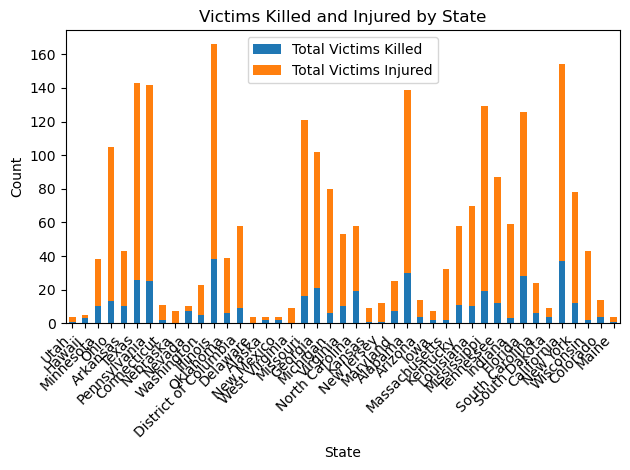

In [59]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

df1 = df.repartition(df.rdd.getNumPartitions())  # Crea una copia independientemente particionada

# Agrupamos por estado y sumamos las columnas 'Victims Killed' y 'Victims Injured'
df1 = df.groupBy('State').agg(
    F.sum('Victims Killed').alias('Total Victims Killed'),
    F.sum('Victims Injured').alias('Total Victims Injured')
)

# Convertimos el DataFrame a Pandas para facilidad de graficado
df1_pandas = df1.toPandas()

# Creamos el primer gráfico (Victims Killed vs Victims Injured por estado)
plt.figure(figsize=(15, 8))
df1_pandas.set_index('State')[['Total Victims Killed', 'Total Victims Injured']].plot(kind='bar', stacked=True)
plt.title('Victims Killed and Injured by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

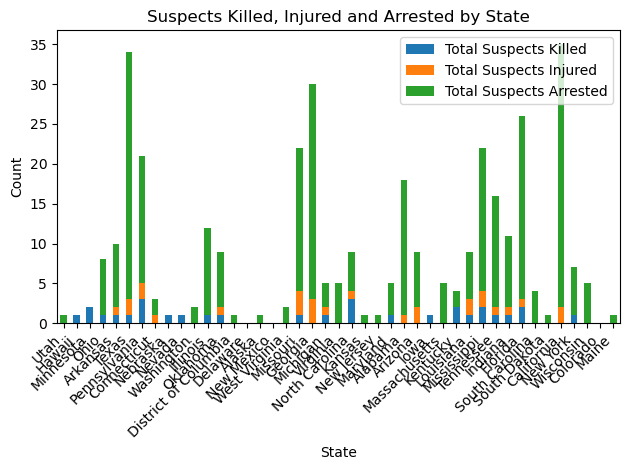

In [60]:
from pyspark.sql import functions as F

# Creamos una copia del DataFrame original (df) y trabajamos con ella
df2 = df.select("*")  # Hacemos una copia superficial del DataFrame original

# Agrupamos por estado y sumamos las columnas 'Suspects Killed', 'Suspects Injured' y 'Suspects Arrested'
df2 = df.groupBy('State').agg(
    F.sum('Suspects Killed').alias('Total Suspects Killed'),
    F.sum('Suspects Injured').alias('Total Suspects Injured'),
    F.sum('Suspects Arrested').alias('Total Suspects Arrested')
)

# Convertimos el DataFrame a Pandas para facilidad de graficado
df2_pandas = df2.toPandas()

# Creamos el segundo gráfico (Suspects Killed, Injured and Arrested por estado)
plt.figure(figsize=(10, 6))
df2_pandas.set_index('State')[['Total Suspects Killed', 'Total Suspects Injured', 'Total Suspects Arrested']].plot(kind='bar', stacked=True)
plt.title('Suspects Killed, Injured and Arrested by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [61]:
df.count()

427

In [62]:
from pyspark.sql import functions as F

# Extraemos el Año y el Mes de la columna 'Incident Date'
df = df.withColumn('Year', F.year(df['Incident Date']))  # Extrae el año
df = df.withColumn('Month', F.month(df['Incident Date']))  # Extrae el mes

# Agrupamos por Año y Mes, y contamos el número de registros para cada combinación
result = df.groupBy('Year', 'Month').count().orderBy('Year', 'Month')

# Mostrar los resultados
result.show(truncate=False)

+----+-----+-----+
|Year|Month|count|
+----+-----+-----+
|2024|1    |38   |
|2024|2    |27   |
|2024|3    |34   |
|2024|4    |37   |
|2024|5    |52   |
|2024|6    |72   |
|2024|7    |62   |
|2024|8    |52   |
|2024|9    |36   |
|2024|10   |17   |
+----+-----+-----+



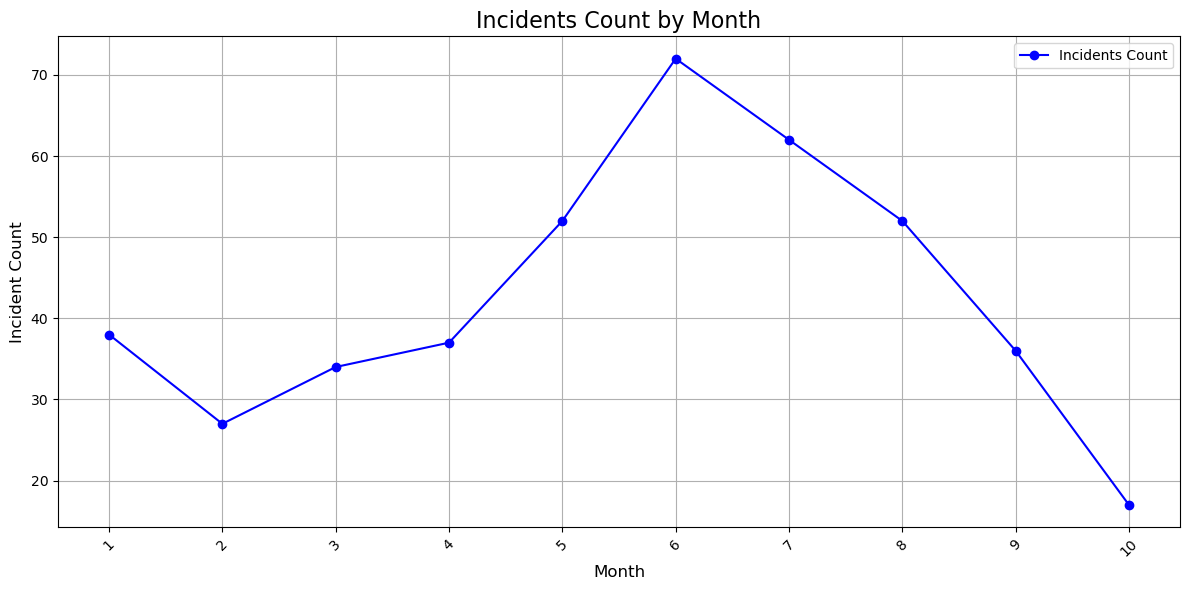

In [63]:
# Convertimos el DataFrame de PySpark a Pandas para facilitar la visualización
result_pandas = result.toPandas()

# Crear un gráfico lineal
plt.figure(figsize=(12, 6))  # Ajustamos el tamaño de la figura
plt.plot(result_pandas['Month'], result_pandas['count'], marker='o', linestyle='-', color='b', label='Incidents Count')

# Configuración del gráfico
plt.title('Incidents Count by Month', fontsize=16)  # Título del gráfico
plt.xlabel('Month', fontsize=12)  # Etiqueta en el eje X
plt.ylabel('Incident Count', fontsize=12)  # Etiqueta en el eje Y
plt.xticks(result_pandas['Month'], rotation=45)  # Rotamos las etiquetas del mes para mejor visualización
plt.grid(True)  # Activamos la cuadrícula
plt.tight_layout()  # Ajustamos el layout para evitar el solapamiento

# Mostrar el gráfico
plt.legend()
plt.show()

In [64]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Filtrar las filas donde hay al menos una víctima asesinada
df_filtered = df.filter(df['Victims Killed'] > 0)

# Agrupar por 'State', sumando las víctimas asesinadas y los arrestos
result = df_filtered.groupBy('State').agg(
    F.sum('Victims Killed').alias('Total Victims Killed'),
    F.sum('Suspects Arrested').alias('Total Suspects Arrested')
).orderBy('Total Victims Killed', ascending=False)

# Mostrar los resultados
result.show(truncate=False)

+--------------------+--------------------+-----------------------+
|State               |Total Victims Killed|Total Suspects Arrested|
+--------------------+--------------------+-----------------------+
|Illinois            |38                  |11                     |
|California          |37                  |17                     |
|Alabama             |30                  |16                     |
|Florida             |28                  |14                     |
|Texas               |26                  |18                     |
|Pennsylvania        |25                  |7                      |
|Georgia             |21                  |12                     |
|North Carolina      |19                  |5                      |
|Mississippi         |19                  |13                     |
|Missouri            |16                  |14                     |
|Ohio                |13                  |5                      |
|Tennessee           |12                  |6    

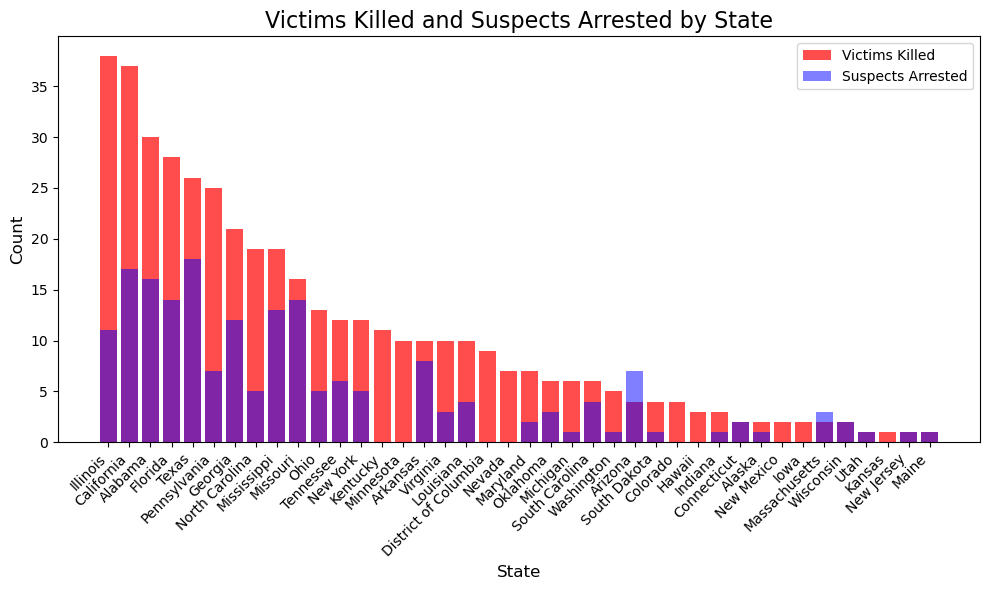

In [65]:
# Convertimos el resultado a Pandas
result_pandas = result.toPandas()

# Creamos el gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Graficamos las víctimas asesinadas
ax.bar(result_pandas['State'], result_pandas['Total Victims Killed'], label='Victims Killed', alpha=0.7, color='red')

# Graficamos los arrestos en el mismo gráfico
ax.bar(result_pandas['State'], result_pandas['Total Suspects Arrested'], label='Suspects Arrested', alpha=0.5, color='blue')

# Añadimos etiquetas y título
plt.title('Victims Killed and Suspects Arrested by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Añadimos la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


In [66]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Agrupar por 'City Or County', sumando las víctimas heridas y asesinadas
df_grouped = df.groupBy('City Or County').agg(
    F.sum('Victims Killed').alias('Total Victims Killed'),
    F.sum('Victims Injured').alias('Total Victims Injured')
).orderBy(F.desc('Total Victims Killed'))

# Convertimos el resultado a Pandas para graficarlo
df_grouped_pandas = df_grouped.toPandas()

# Mostramos las primeras filas
df_grouped_pandas.head()


,City Or County,Total Victims Killed,Total Victims Injured
0,Birmingham,15,35
1,Chicago,15,117
2,Philadelphia,12,71
3,Richmond,10,15
4,Washington,9,49


<Figure size 1600x1200 with 0 Axes>

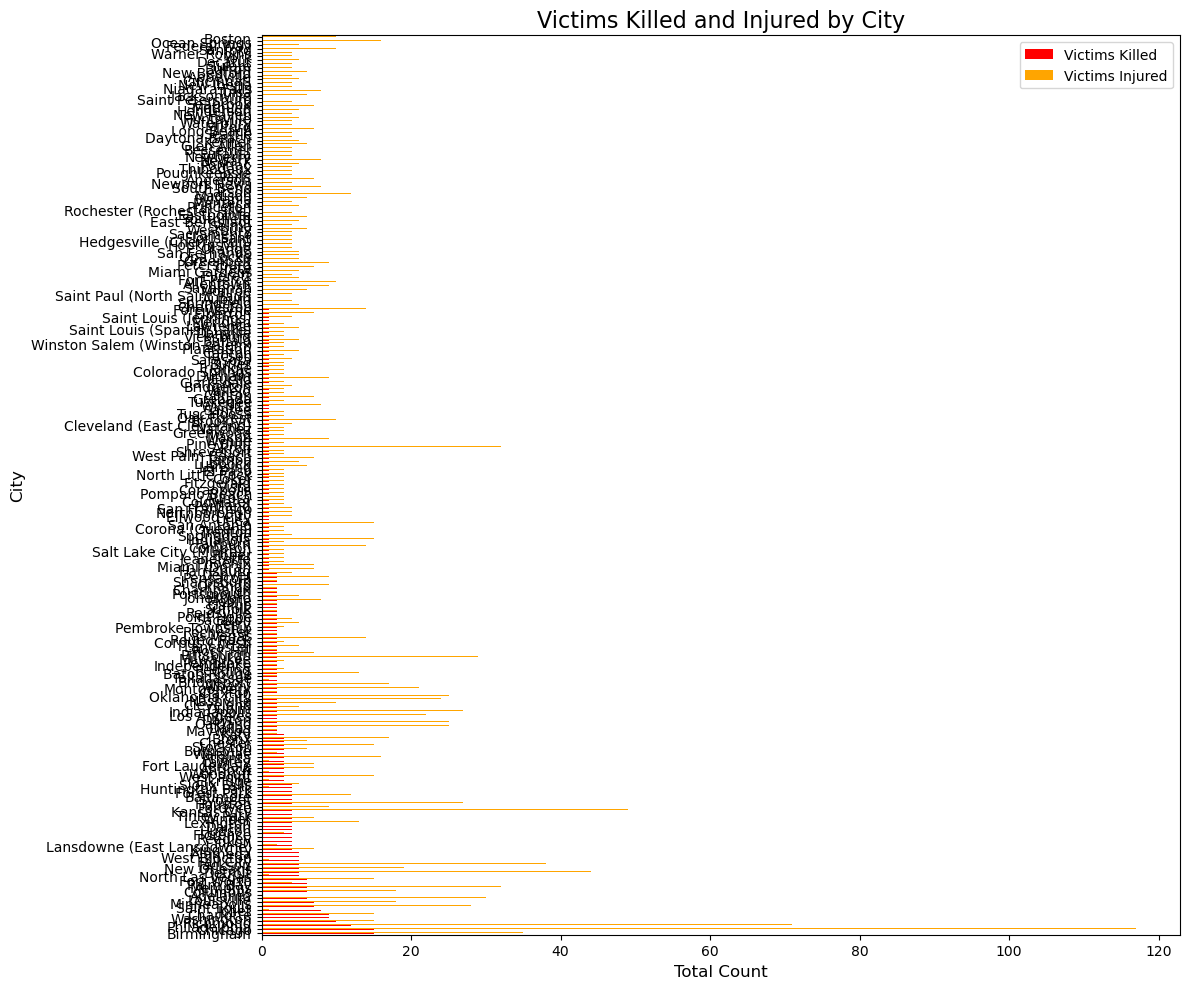

In [67]:
# Aumentar el tamaño del gráfico
plt.figure(figsize=(16, 12))

# Mostrar las barras separadas para 'Victims Killed' y 'Victims Injured'
df_grouped_pandas.set_index('City Or County')[['Total Victims Killed', 'Total Victims Injured']].plot(kind='barh', figsize=(12, 10), color=['red', 'orange'])

# Añadimos título y etiquetas
plt.title('Victims Killed and Injured by City', fontsize=16)
plt.xlabel('Total Count', fontsize=12)
plt.ylabel('City', fontsize=12)

# Añadimos leyenda
plt.legend(['Victims Killed', 'Victims Injured'], loc='upper right')

# Ajustamos la visualización
plt.tight_layout()

# Mostramos el gráfico
plt.show()


<Figure size 1200x800 with 0 Axes>

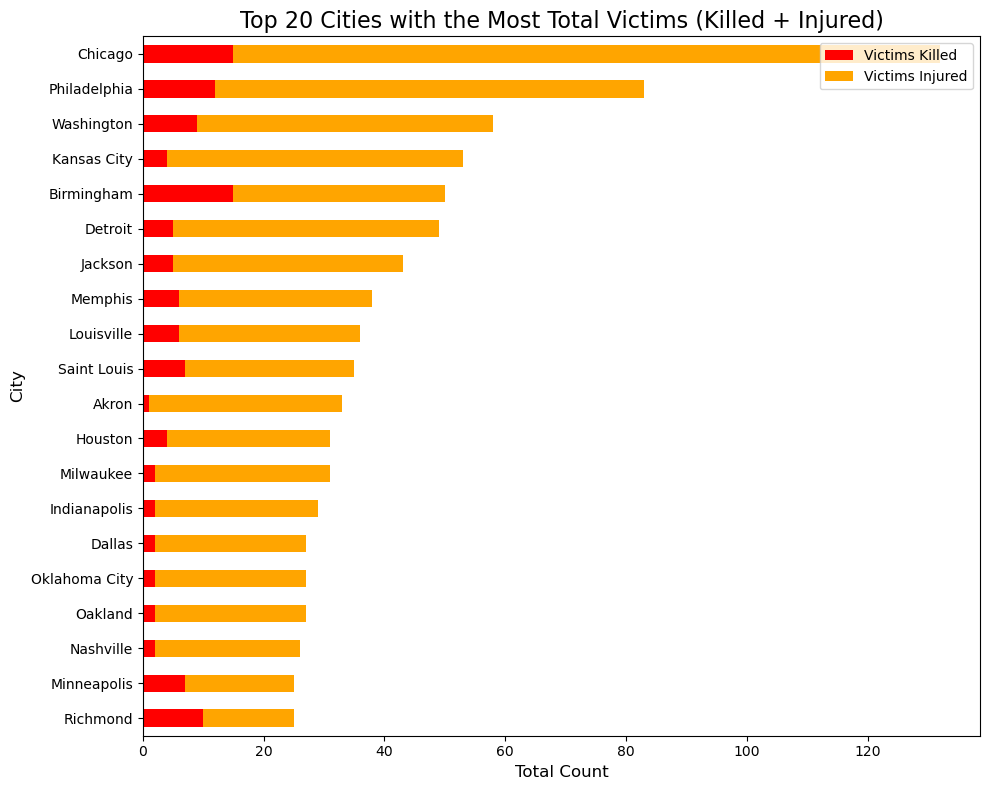

In [68]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Agrupar por 'City Or County', sumando las víctimas heridas y asesinadas
df_grouped = df.groupBy('City Or County').agg(
    F.sum('Victims Killed').alias('Total Victims Killed'),
    F.sum('Victims Injured').alias('Total Victims Injured')
)

# Convertir el resultado a Pandas para facilitar el procesamiento y graficado
df_grouped_pandas = df_grouped.toPandas()

# Crear una nueva columna que sume las víctimas heridas y asesinadas
df_grouped_pandas['Total Victims'] = df_grouped_pandas['Total Victims Killed'] + df_grouped_pandas['Total Victims Injured']

# Ordenar las ciudades por la suma total de víctimas (heridas + asesinadas), de mayor a menor
df_grouped_pandas = df_grouped_pandas.sort_values(by='Total Victims', ascending=False)

# Limitar a las top 20 ciudades con más víctimas
df_grouped_pandas = df_grouped_pandas.head(20)

# Crear el gráfico de barras horizontales
plt.figure(figsize=(12, 8))

# Mostrar las barras separadas para 'Victims Killed' y 'Victims Injured'
df_grouped_pandas.set_index('City Or County')[['Total Victims Killed', 'Total Victims Injured']].plot(kind='barh', stacked=True, figsize=(10, 8), color=['red', 'orange'])

# Añadir título y etiquetas
plt.title('Top 20 Cities with the Most Total Victims (Killed + Injured)', fontsize=16)
plt.xlabel('Total Count', fontsize=12)
plt.ylabel('City', fontsize=12)

# Añadir leyenda
plt.legend(['Victims Killed', 'Victims Injured'], loc='upper right')

# Invertir el eje Y para que la ciudad con más víctimas aparezca en la parte superior
plt.gca().invert_yaxis()

# Ajustar la visualización
plt.tight_layout()

# Mostrar el gráfico
plt.show()



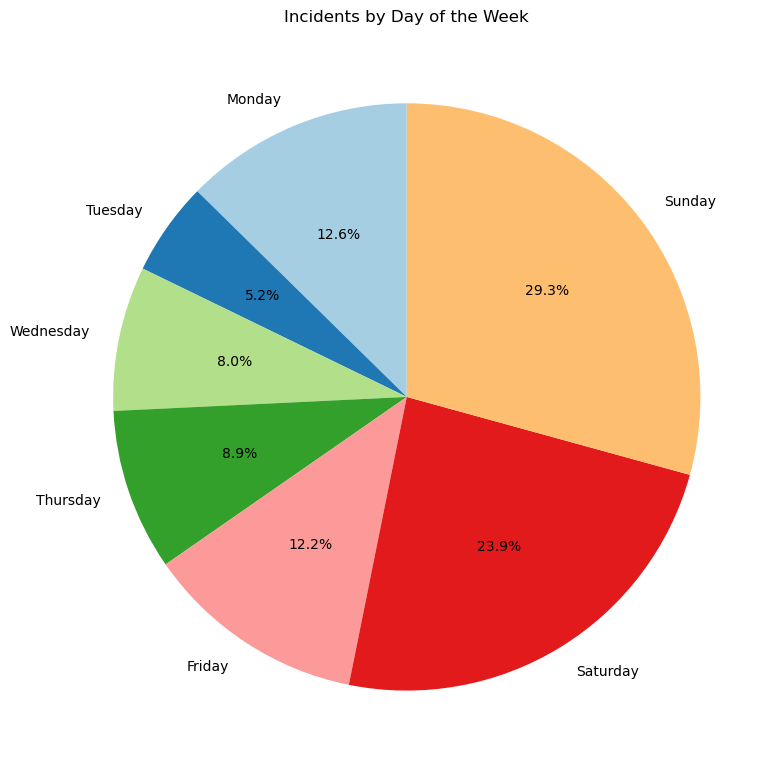

In [69]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd 

# Extraemos el día de la semana con el formato de texto (Ejemplo: 'Monday', 'Tuesday', etc.)
df = df.withColumn('Day_of_Week', F.date_format(df['Incident Date'], 'EEEE'))

# Agrupamos por 'Day_of_Week' y contamos el número de incidentes por día
df_day_of_week = df.groupBy('Day_of_Week').count()

# Convertimos a Pandas para facilidad de graficado
df_day_of_week_pandas = df_day_of_week.toPandas()

# Para asegurar que los días de la semana se ordenen correctamente
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_day_of_week_pandas['Day_of_Week'] = pd.Categorical(df_day_of_week_pandas['Day_of_Week'], categories=days_order, ordered=True)
df_day_of_week_pandas = df_day_of_week_pandas.sort_values('Day_of_Week')

# Creamos el gráfico de pastel
plt.figure(figsize=(8, 8))

# Grafico de pastel
plt.pie(df_day_of_week_pandas['count'], labels=df_day_of_week_pandas['Day_of_Week'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

# Añadimos título
plt.title('Incidents by Day of the Week')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [70]:
!pip install folium --break-system-packages

Defaulting to user installation because normal site-packages is not writeable


In [71]:
df.show()

+-----------+-------------+--------------------+--------------------+--------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+----------+-----------------+----+-----+-----------+
|Incident ID|Incident Date|               State|      City Or County|             Address|Victims Killed|Victims Injured|Suspects Killed|Suspects Injured|Suspects Arrested|Operations|Latitude| Longitude|Coordinates_Found|Year|Month|Day_of_Week|
+-----------+-------------+--------------------+--------------------+--------------------+--------------+---------------+---------------+----------------+-----------------+----------+--------+----------+-----------------+----+-----+-----------+
|    3052758|   2024-10-21|          Washington|           Fall City|7700 block of Lak...|             5|              1|              0|               0|                1|      NULL|47.56812|-121.89086|              Yes|2024|   10|     Monday|
|    3052028|   2024

In [75]:
import folium
import pandas as pd

# Convertimos el DataFrame de PySpark a pandas
df_pandas = df.toPandas()  # Convertimos a pandas para poder usar iterrows

# Creamos un mapa centrado en Estados Unidos para representar a las víctimas asesinadas
map_killed = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Agregamos marcadores para las víctimas asesinadas
for i, row in df_pandas.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],  # Ubicación basada en latitud y longitud
        radius=row['Victims Killed'] * 2,  # Escalar el radio del círculo según el número de víctimas
        color='red',  # Color del borde del marcador
        fill=True,  # Relleno del marcador
        fill_color='red',  # Color de relleno del marcador
        fill_opacity=0.6,  # Opacidad del relleno para mayor visibilidad
        popup=f"{row['City Or County']} - {row['Victims Killed']} killed"  # Mensaje emergente con detalles
    ).add_to(map_killed)  # Agregar el marcador al mapa

# Mostrar el mapa de víctimas asesinadas
map_killed



In [76]:
map_injured = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Agregamos marcadores para las víctimas heridas
for i, row in df_pandas.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],  # Ubicación basada en latitud y longitud
        radius=row['Victims Injured'] * 2,  # Escalando el radio del círculo según el número de víctimas heridas
        color='green',  # Color del borde del marcador
        fill=True,  # Relleno del marcador
        fill_color='green',  # Color de relleno del marcador
        fill_opacity=0.6,  # Opacidad del relleno para mejor visibilidad
        popup=f"{row['City Or County']} - {row['Victims Injured']} injured"  # Mensaje emergente con detalles
    ).add_to(map_injured)  # Agregar el marcador al mapa

# Mostrar el mapa de víctimas heridas en un Jupyter Notebook (o guardarlo)
map_injured

In [77]:
from folium.plugins import MarkerCluster

# Creamos un mapa centrado en los Estados Unidos para representar a las víctimas asesinadas
map_killed = folium.Map(location=[39.8283, -98.5795], zoom_start=4)  # Centrado en los Estados Unidos
killed_cluster = MarkerCluster(name="Victims Killed").add_to(map_killed)  # Agrupación de marcadores para mayor claridad

# Agregamos marcadores al cluster de víctimas asesinadas
for i, row in df_pandas.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],  # Ubicación basada en latitud y longitud
        radius=row['Victims Killed'] * 2,  # Escalando el radio del círculo según el número de víctimas asesinadas
        color='red',  # Color del borde del marcador
        fill=True,  # Relleno del marcador
        fill_color='red',  # Color de relleno del marcador
        fill_opacity=0.6,  # Opacidad del relleno para mejor visibilidad
        popup=f"{row['City Or County']} - {row['Victims Killed']} killed"  # Mensaje emergente con detalles
    ).add_to(killed_cluster)  # Agregar el marcador al cluster

# Mostrar el mapa de víctimas asesinadas en un Jupyter Notebook (o guardarlo)
map_killed

In [78]:
# Creamos un mapa centrado en los Estados Unidos
cluster_map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)  # Centrado en los Estados Unidos
marker_cluster = MarkerCluster().add_to(cluster_map)  # Añadimos un cluster para agrupar los marcadores

# Agregamos marcadores para cada incidente
for i, row in df_pandas.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],  # Ubicación basada en latitud y longitud
        popup=(f"City: {row['City Or County']}<br>"
               f"Killed: {row['Victims Killed']}<br>"
               f"Injured: {row['Victims Injured']}")  # Mensaje emergente con detalles de la ciudad, asesinados y heridos
    ).add_to(marker_cluster)  # Agregar el marcador al cluster

# Mostrar el mapa con el cluster en un Jupyter Notebook (o guardarlo)
cluster_map

In [79]:
from folium.plugins import HeatMap

# Preparamos los datos para el mapa de calor, extrayendo latitud y longitud de cada fila
heat_data = [[row['Latitude'], row['Longitude']] for index, row in df_pandas.iterrows()]

# Creamos un mapa centrado en los Estados Unidos
incident_heatmap = folium.Map(location=[39.8283, -98.5795], zoom_start=4)  # Centrado en los Estados Unidos

# Agregamos la capa de mapa de calor con los datos de ubicación de cada incidente
HeatMap(heat_data).add_to(incident_heatmap)

# Mostrar el mapa de calor en un Jupyter Notebook (o guardarlo)
incident_heatmap

### A continuación, prepararemos una estructura de datos de ejemplo. 
### Supongamos que hemos cargado el dataset con las siguientes columnas: CRIM (índice de criminalidad per cápita), ZN (proporción de terreno residencial), INDUS (proporción de acres de negocio), RM (número medio de habitaciones por vivienda), y MEDV (precio medio de la vivienda en miles de dólares), entre otras.

In [80]:
# dataset --> https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data

# Reemplazar múltiples espacios por un solo espacio en el archivo CSV
input_file = "housing.csv"
output_file = "housing_processed.csv"

# Leer el archivo original y reemplazar múltiples espacios por un solo espacio
with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
    for line in infile:
        # Reemplazar múltiples espacios por un solo espacio
        cleaned_line = ' '.join(line.split())
        outfile.write(cleaned_line + '\n')

print(f"Archivo procesado guardado en: {output_file}")

Archivo procesado guardado en: housing_processed.csv


In [81]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


# Crear una sesión de Spark
spark = SparkSession.builder.appName("HousingPricePrediction").getOrCreate()

# Cargar el archivo procesado en Spark
df_raw = spark.read.csv("housing_processed.csv", sep=" ", inferSchema=True, header=False)

# Definir nombres de columnas según el dataset de Boston Housing
column_names = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]

# Verificar las primeras filas para confirmar el número de columnas
df_raw.show(5)

# Asignar los nombres de las columnas manualmente
df = df_raw.toDF(*column_names)

# Verificar el esquema y los datos
df.printSchema()
df.show(5)


24/11/06 10:14:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+-------+----+----+---+-----+-----+----+------+---+-----+----+------+----+----+
|    _c0| _c1| _c2|_c3|  _c4|  _c5| _c6|   _c7|_c8|  _c9|_c10|  _c11|_c12|_c13|
+-------+----+----+---+-----+-----+----+------+---+-----+----+------+----+----+
|0.00632|18.0|2.31|  0|0.538|6.575|65.2|  4.09|  1|296.0|15.3| 396.9|4.98|24.0|
|0.02731| 0.0|7.07|  0|0.469|6.421|78.9|4.9671|  2|242.0|17.8| 396.9|9.14|21.6|
|0.02729| 0.0|7.07|  0|0.469|7.185|61.1|4.9671|  2|242.0|17.8|392.83|4.03|34.7|
|0.03237| 0.0|2.18|  0|0.458|6.998|45.8|6.0622|  3|222.0|18.7|394.63|2.94|33.4|
|0.06905| 0.0|2.18|  0|0.458|7.147|54.2|6.0622|  3|222.0|18.7| 396.9|5.33|36.2|
+-------+----+----+---+-----+-----+----+------+---+-----+----+------+----+----+
only showing top 5 rows

root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |

In [82]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Crear una sesión de Spark
spark = SparkSession.builder.appName("HousingPricePrediction").getOrCreate()

# Cargar el archivo procesado en Spark
df_raw = spark.read.csv("housing_processed.csv", sep=" ", inferSchema=True, header=False)

# Definir nombres de columnas según el dataset de Boston Housing
column_names = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]

# Asignar los nombres de las columnas manualmente
df = df_raw.toDF(*column_names)

# Verificar el esquema y los datos
df.printSchema()
df.show(5)

# Especificar las columnas que se usarán como características
feature_columns = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]

# Crear el vector de características
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(df)

# Dividir los datos en conjunto de entrenamiento y prueba
train_data, test_data = df_assembled.randomSplit([0.8, 0.2], seed=1234)

# Configurar y entrenar el modelo de regresión lineal (utilizando "MEDV" como etiqueta)
lr = LinearRegression(featuresCol="features", labelCol="MEDV")
lr_model = lr.fit(train_data)

# Hacer predicciones
predictions = lr_model.transform(test_data)

# Mostrar las predicciones
predictions.select("features", "MEDV", "prediction").show()

# Evaluar el modelo
evaluator = RegressionEvaluator(labelCol="MEDV", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE en el modelo de regresión lineal: {rmse}")


root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: double (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- MEDV: double (nullable = true)

+-------+----+-----+----+-----+-----+----+------+---+-----+-------+------+-----+----+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM| AGE|   DIS|RAD|  TAX|PTRATIO|     B|LSTAT|MEDV|
+-------+----+-----+----+-----+-----+----+------+---+-----+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296.0|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242.0|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242.0|   17.

24/11/06 10:14:15 WARN Instrumentation: [add43bfd] regParam is zero, which might cause numerical instability and overfitting.
24/11/06 10:14:15 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


+--------------------+----+------------------+
|            features|MEDV|        prediction|
+--------------------+----+------------------+
|[0.00906,90.0,2.9...|32.2| 31.99289238577526|
|[0.01311,90.0,1.2...|35.4| 30.86174226047695|
|[0.02498,0.0,1.89...|16.5|21.739350064389328|
|[0.02731,0.0,7.07...|21.6|25.159805087588282|
|[0.02763,75.0,2.9...|30.8|31.436005134696337|
|[0.02875,28.0,15....|25.0|29.602526169654773|
|[0.02899,40.0,1.2...|26.6|21.377563475706296|
|[0.03427,0.0,5.19...|19.5|19.509953789475677|
|[0.03584,80.0,3.3...|23.5|30.668929278188962|
|[0.03659,25.0,4.8...|24.8| 25.93606996217156|
|[0.03932,0.0,3.41...|22.0| 27.59324921783439|
|[0.04203,28.0,15....|22.9| 29.60333742126887|
|[0.04294,28.0,15....|20.6| 27.83490790919844|
|[0.04297,52.5,5.3...|24.8| 27.04314629470237|
|[0.04462,25.0,4.8...|23.9|27.081390760022586|
|[0.0456,0.0,13.89...|23.3|26.518673384219937|
|[0.04819,80.0,3.6...|21.9|23.943432218761146|
|[0.04932,33.0,2.1...|28.2| 32.94016669053606|
|[0.05083,0.0

In [83]:
# Árbol de Decisión para Regresión

from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Crear el modelo de Árbol de Decisión para regresión
dt = DecisionTreeRegressor(featuresCol="features", labelCol="MEDV")

# Entrenar el modelo
dt_model = dt.fit(train_data)

# Hacer predicciones
dt_predictions = dt_model.transform(test_data)

# Mostrar las predicciones
dt_predictions.select("features", "MEDV", "prediction").show()

# Evaluar el modelo
evaluator = RegressionEvaluator(labelCol="MEDV", predictionCol="prediction", metricName="rmse")
dt_rmse = evaluator.evaluate(dt_predictions)
print(f"RMSE en el modelo de Árbol de Decisión: {dt_rmse}")



+--------------------+----+------------------+
|            features|MEDV|        prediction|
+--------------------+----+------------------+
|[0.00906,90.0,2.9...|32.2|             30.68|
|[0.01311,90.0,1.2...|35.4| 33.45897435897435|
|[0.02498,0.0,1.89...|16.5|20.371812080536913|
|[0.02731,0.0,7.07...|21.6|20.371812080536913|
|[0.02763,75.0,2.9...|30.8|27.342857142857138|
|[0.02875,28.0,15....|25.0| 24.07857142857143|
|[0.02899,40.0,1.2...|26.6|              23.5|
|[0.03427,0.0,5.19...|19.5|20.371812080536913|
|[0.03584,80.0,3.3...|23.5| 24.07857142857143|
|[0.03659,25.0,4.8...|24.8| 24.07857142857143|
|[0.03932,0.0,3.41...|22.0|20.371812080536913|
|[0.04203,28.0,15....|22.9|20.371812080536913|
|[0.04294,28.0,15....|20.6|20.371812080536913|
|[0.04297,52.5,5.3...|24.8|             22.32|
|[0.04462,25.0,4.8...|23.9|27.342857142857138|
|[0.0456,0.0,13.89...|23.3|20.371812080536913|
|[0.04819,80.0,3.6...|21.9| 24.07857142857143|
|[0.04932,33.0,2.1...|28.2| 33.45897435897435|
|[0.05083,0.0

In [84]:
# Random Forest para Regresión

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Crear el modelo de Random Forest para regresión
rf = RandomForestRegressor(featuresCol="features", labelCol="MEDV")

# Entrenar el modelo
rf_model = rf.fit(train_data)

# Hacer predicciones
rf_predictions = rf_model.transform(test_data)

# Mostrar las predicciones
rf_predictions.select("features", "MEDV", "prediction").show()

# Evaluar el modelo
rf_rmse = evaluator.evaluate(rf_predictions)
print(f"RMSE en el modelo de Random Forest: {rf_rmse}")



+--------------------+----+------------------+
|            features|MEDV|        prediction|
+--------------------+----+------------------+
|[0.00906,90.0,2.9...|32.2|31.357326539347593|
|[0.01311,90.0,1.2...|35.4|34.325947737593786|
|[0.02498,0.0,1.89...|16.5| 23.65423469916192|
|[0.02731,0.0,7.07...|21.6|22.384398166352153|
|[0.02763,75.0,2.9...|30.8|27.953901084422824|
|[0.02875,28.0,15....|25.0|23.381199867156653|
|[0.02899,40.0,1.2...|26.6| 29.63189220391707|
|[0.03427,0.0,5.19...|19.5|20.418759252883103|
|[0.03584,80.0,3.3...|23.5|25.735115546135127|
|[0.03659,25.0,4.8...|24.8| 23.40874626754845|
|[0.03932,0.0,3.41...|22.0|23.283507748166134|
|[0.04203,28.0,15....|22.9|22.907109366796483|
|[0.04294,28.0,15....|20.6| 21.60238880655935|
|[0.04297,52.5,5.3...|24.8|23.498884685786273|
|[0.04462,25.0,4.8...|23.9|24.511425138550567|
|[0.0456,0.0,13.89...|23.3|20.937585109617487|
|[0.04819,80.0,3.6...|21.9|23.637859601903493|
|[0.04932,33.0,2.1...|28.2|27.982428789537135|
|[0.05083,0.0

In [85]:
# Gradient-Boosted Trees para Regresión

from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Crear el modelo de Gradient-Boosted Trees para regresión
gbt = GBTRegressor(featuresCol="features", labelCol="MEDV")

# Entrenar el modelo
gbt_model = gbt.fit(train_data)

# Hacer predicciones
gbt_predictions = gbt_model.transform(test_data)

# Mostrar las predicciones
gbt_predictions.select("features", "MEDV", "prediction").show()

# Evaluar el modelo
gbt_rmse = evaluator.evaluate(gbt_predictions)
print(f"RMSE en el modelo de Gradient-Boosted Trees: {gbt_rmse}")


+--------------------+----+------------------+
|            features|MEDV|        prediction|
+--------------------+----+------------------+
|[0.00906,90.0,2.9...|32.2|31.016347790441056|
|[0.01311,90.0,1.2...|35.4| 32.53977159053911|
|[0.02498,0.0,1.89...|16.5| 20.58108583481355|
|[0.02731,0.0,7.07...|21.6| 21.92679919075085|
|[0.02763,75.0,2.9...|30.8| 28.77556884501294|
|[0.02875,28.0,15....|25.0|24.179425689624097|
|[0.02899,40.0,1.2...|26.6|22.517884081694145|
|[0.03427,0.0,5.19...|19.5|19.389782823547453|
|[0.03584,80.0,3.3...|23.5|24.236471165216017|
|[0.03659,25.0,4.8...|24.8|22.575582391300646|
|[0.03932,0.0,3.41...|22.0| 21.49448128636692|
|[0.04203,28.0,15....|22.9|22.605606116764747|
|[0.04294,28.0,15....|20.6| 20.70135815840753|
|[0.04297,52.5,5.3...|24.8| 21.96689801418534|
|[0.04462,25.0,4.8...|23.9|25.187321417461423|
|[0.0456,0.0,13.89...|23.3| 20.75622668509373|
|[0.04819,80.0,3.6...|21.9|23.688174256858847|
|[0.04932,33.0,2.1...|28.2|32.422408215377466|
|[0.05083,0.0